In [ ]:
url = 'http://dapds00.nci.org.au/thredds/dodsC/gb6/BRAN/BRAN_2016/OFAM/ocean_eta_t_2000_01.nc'

In [ ]:
import xarray
import numpy as np

In [ ]:
data = xarray.open_dataset(url)

In [ ]:
eta_t = data['eta_t']

In [ ]:
eta_t_numpy = np.array(eta_t)

In [ ]:
eta_t_numpy = np.nan_to_num(eta_t_numpy)

In [ ]:
eta_t_numpy.shape

In [ ]:
day1_eta_t = eta_t_numpy[0,:,:]

In [ ]:
day1_eta_t.shape

(1500, 3600)

In [ ]:
day1_eta_t_padded[200:210,200:210]

NameError: ignored

In [ ]:
day1_eta_t_padded = np.zeros((1536,3712))
day1_eta_t_padded[:day1_eta_t.shape[0],:day1_eta_t.shape[1]] = day1_eta_t

In [ ]:
day1_eta_t_padded.shape

(1536, 3712)

In [ ]:
dataset = []

i=0
j=128

while i < 1536:
  m = 0
  n = 128
  while m < 3712:
    matrix = day1_eta_t_padded[i:j,m:n]
    matrix = np.expand_dims(matrix,axis=2)
    dataset.append(matrix)
    m += 128
    n += 128
  i += 128
  j += 128


In [ ]:
dataset = np.array(dataset)

In [ ]:
dataset.shape

(348, 128, 128, 1)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation, MaxPool2D, UpSampling2D
from tensorflow.keras.layers import BatchNormalization, Flatten, Reshape, Conv2DTranspose, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

In [ ]:
data_inputs = Input(shape=(128,128,1))

x = Conv2D(16,(3,3),activation='relu',padding='same')(data_inputs)
#x = BatchNormalization()(x)
x = MaxPool2D((2,2),padding='same')(x)
x = Conv2D(8,(3,3),activation='relu',padding='same')(x)
#x = BatchNormalization()(x)
x = MaxPool2D((2,2),padding='same')(x)
x = Conv2D(8,(3,3),activation='relu',padding='same')(x)
encoded = MaxPool2D((2,2),padding='same')(x)

x = Conv2D(8,(3,3),activation='relu',padding='same')(encoded)
x = UpSampling2D((2,2))(x)
x = Conv2D(8,(3,3),activation='relu',padding='same')(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(16,(3,3),activation='relu',padding='same')(x)
x = UpSampling2D((2,2))(x)
decoded = Conv2D(1,(3,3),activation='relu',padding='same')(x)

autoencoder = Model(data_inputs,decoded)
autoencoder.compile(optimizer='adam',loss='mse')

In [ ]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 8)         584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 8)         0     

In [ ]:
np.random.shuffle(dataset)
print(dataset.shape)
train_inputs = dataset[:278,:,:,:]
val_inputs = dataset[278:348,:,:,:]

(348, 128, 128, 1)


In [ ]:
history = autoencoder.fit(train_inputs, train_inputs, epochs=20,validation_data=(val_inputs,val_inputs))

Epoch 1/20
9/9 [==============================] - 8s 797ms/step - loss: 0.3841 - val_loss: 0.2478
Epoch 2/20
9/9 [==============================] - 7s 770ms/step - loss: 0.3533 - val_loss: 0.2475
Epoch 3/20
9/9 [==============================] - 7s 760ms/step - loss: 0.3510 - val_loss: 0.2451
Epoch 4/20
9/9 [==============================] - 7s 762ms/step - loss: 0.3494 - val_loss: 0.2440
Epoch 5/20
9/9 [==============================] - 7s 763ms/step - loss: 0.3486 - val_loss: 0.2436
Epoch 6/20
9/9 [==============================] - 7s 762ms/step - loss: 0.3480 - val_loss: 0.2433
Epoch 7/20
9/9 [==============================] - 7s 764ms/step - loss: 0.3473 - val_loss: 0.2425
Epoch 8/20
9/9 [==============================] - 7s 764ms/step - loss: 0.3466 - val_loss: 0.2421
Epoch 9/20
9/9 [==============================] - 7s 767ms/step - loss: 0.3461 - val_loss: 0.2419
Epoch 10/20
9/9 [==============================] - 7s 769ms/step - loss: 0.3458 - val_loss: 0.2419
Epoch 11/20
9/9 [==

dict_keys(['loss', 'val_loss'])


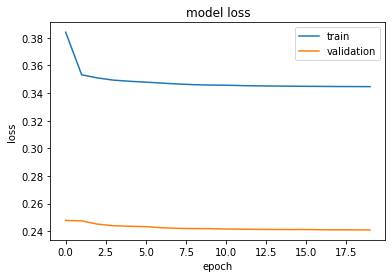

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
encoder = Model(data_inputs,encoded)

In [ ]:
encoded_data = encoder.predict(np.array([dataset[-1]]))

In [ ]:
encoded_data.shape

(1, 16, 16, 8)

In [ ]:
encoded_data.nbytes

8192

In [ ]:
decoded_data = autoencoder.predict(np.array([dataset[-1]]))

In [ ]:
decoded_data.shape

(1, 128, 128, 1)

In [ ]:
decoded_data.nbytes

65536

In [ ]:
decoded_data[0,:10,:10,0]

NameError: ignored

In [ ]:
dataset[-1,:10,:10,0]

array([[0.21362957, 0.21362957, 0.21362957, 0.24414808, 0.24414808,
        0.24414808, 0.24414808, 0.24414808, 0.24414808, 0.24414808],
       [0.21362957, 0.21362957, 0.21362957, 0.21362957, 0.21362957,
        0.24414808, 0.24414808, 0.24414808, 0.24414808, 0.24414808],
       [0.21362957, 0.21362957, 0.21362957, 0.21362957, 0.21362957,
        0.21362957, 0.24414808, 0.24414808, 0.24414808, 0.24414808],
       [0.21362957, 0.21362957, 0.21362957, 0.21362957, 0.21362957,
        0.21362957, 0.21362957, 0.24414808, 0.24414808, 0.24414808],
       [0.18311106, 0.21362957, 0.21362957, 0.21362957, 0.21362957,
        0.21362957, 0.21362957, 0.21362957, 0.24414808, 0.24414808],
       [0.18311106, 0.18311106, 0.21362957, 0.21362957, 0.21362957,
        0.21362957, 0.21362957, 0.21362957, 0.21362957, 0.24414808],
       [0.18311106, 0.21362957, 0.21362957, 0.21362957, 0.21362957,
        0.21362957, 0.21362957, 0.21362957, 0.21362957, 0.24414808],
       [0.21362957, 0.21362957, 0.2136295